# Deep Learning for NLP: Machine Translation Exercise (Solution)

**The classes for the new attention models are in the cells at the end of this notebook. Just keep in mind that you'll have to change one line in the decoder to use one of the new attention models.**

In this exercise, we'll carry out some experiments where we investigate the famous attention-based encoder–decoder model presented by [Bahdanau et al. (2015)](https://arxiv.org/pdf/1409.0473.pdf). In particular, we'll take a look at the attention model.

Acknowledgement: the decoder and attention parts have been adapted from [The Annotated Encoder Decoder](https://bastings.github.io/annotated_encoder_decoder/) by Joost Bastings.

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import time
import numpy as np
import sys

import random

import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'svg' 
plt.style.use('seaborn')

You'll have to install the [SacreBLEU](https://github.com/mjpost/sacrebleu) library, which we'll use to compute BLEU scores. It should be enough to do `pip3 install sacrebleu`.

In [2]:
import sacrebleu

As in the previous exercise, we move some utility code into a separate file `mt_util.py` to make this notebook a bit shorter. The utility functions are almost identical to those we used in the sequence labeling exercise:
* `read_lines` to read the tokenized sentences. You'll have to call this for each language separately.
* `Vocabulary` to manage the vocabulary and encode words as integers.
* `SequenceDataset` and `SequenceBatcher` to manage the batches.

In [3]:
import mt_util

## Taking a look at the data

Two parallel datasets have been prepared for this exercise:
* a [German–English dataset](http://www.cse.chalmers.se/~richajo/waspnlp2020/ex3_1/de_en.zip) taken from translations of TED talks.
* a [Swedish–English dataset](http://www.cse.chalmers.se/~richajo/waspnlp2020/ex3_1/sv_en.zip) (smaller package [here](http://www.cse.chalmers.se/~richajo/waspnlp2020/ex3_1/sv_en_small.zip)) from the European Parliament proceedings.

These datasets have been tokenized and aligned at the sentence level. To make our life a bit easier, we've also removed sentences that are longer than 25 words. You can use other datasets if you want (see e.g. [OPUS](http://opus.nlpl.eu/)) but please don't spend too much time preparing the data.

Download the data and take a look at the first sentences. Here's how we can do this for the German–English data.

In [4]:
german_sentences = mt_util.read_lines('de_en/de_en_valid.de', max_lines=10)
english_sentences = mt_util.read_lines('de_en/de_en_valid.en', max_lines=10)

In [5]:
for de, en in zip(german_sentences, english_sentences):
    print(' '.join(de), '/', ' '.join(en))

Als ich 11 Jahre alt war , wurde ich eines Morgens von den Klängen heller Freude geweckt . / When I was 11 , I remember waking up one morning to the sound of joy in my house .
Mein Vater hörte sich auf seinem kleinen , grauen Radio die Nachrichtensendung der BBC an . / My father was listening to BBC News on his small , gray radio .
Er sah sehr glücklich aus , was damals ziemlich ungewöhnlich war , da ihn die Nachrichten meistens deprimierten . / There was a big smile on his face which was unusual then , because the news mostly depressed him .
Er rief : " Die Taliban sind weg ! " / " The Taliban are gone ! " my father shouted .
Ich wusste nicht , was das bedeutete , aber es machte meinen Vater offensichtlich sehr , sehr glücklich . / I did n't know what it meant , but I could see that my father was very , very happy .
" Jetzt kannst du auf eine richtige Schule gehen , " sagte er . / " You can go to a real school now , " he said .
Diesen Morgen werde ich niemals vergessen . / A morning t

## Defining the model

Now we'll define the encoder–decoder neural network.

The high-level container `EncoderDecoder` just wraps the encoder and decoder. We define two methods that we'll use for training and for running the translator, respectively.

* `forward` computes output scores for *teacher forcing* during training.
* `greedy_decode` applies the decoder in a step-by-step manner, selecting the top-scoring word at each position.

In [6]:
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    # S is a batch of source-language sentences, shape (n_sentences, n_source_words).
    # T_shifted contains the corresponding target-language sentences, shifted one step
    #   to the right for teacher forcing, shape (n_sentences, n_target_words).
    def forward(self, S, T_shifted):        
        # Apply the encoder, we get token representations in the source language.
        S_enc = self.encoder(S)

        # Compute a mask that we'll use to get rid of padding tokens when we compute
        # the attention. (We hardcode that the padding token has index 0.)
        S_mask = (S != 0)
        
        # Apply the decoder in teacher forcing mode.
        return self.decoder(S_enc, S_mask, T_shifted)
    
    # S is a batch of source-language sentences, shape (n_sentences, n_source_words).
    # max_len is the maximally allowed sentence length.
    def greedy_decode(self, S, max_len):
        S_enc = self.encoder(S)    
        S_mask = (S != 0)
        return self.decoder.greedy_decode(S_enc, S_mask, max_len)


### The encoder

The encoder is very straightforward. We look up word embeddings and then apply an RNN (a bidirectional GRU in this case) to compute a representation at each token position.

<img src="http://www.cse.chalmers.se/~richajo/waspnlp2020/ex3_1/encoder.svg" alt="Drawing" style="width: 300px;"/>

In [7]:
class Encoder(nn.Module):
    def __init__(self, emb_layer, param):
        super().__init__()
        _, emb_dim = emb_layer.weight.shape       
        self.emb_layer = emb_layer
        self.rnn = nn.GRU(emb_dim, param.enc_rnn_dim, param.enc_rnn_depth, 
                          batch_first=True, bidirectional=True)
        
    def forward(self, S):
        embedded = self.emb_layer(S)
        output, _ = self.rnn(embedded)
        return output

### The decoder

The decoder is also based on a GRU, but this will have to be unidirectional since we're generating in one direction. The GRU is called $f$ in [Bahdanau's paper](https://arxiv.org/pdf/1409.0473.pdf), Section 3.1.
The input to this GRU is a combination of a word embedding of the previous word and a *context* computed by an attention model. This context contains "useful" information from the encoded source sentence.

The output from the GRU is fed into an output word prediction unit, and combined with the previous word embedding and the context. In this implementation, this output unit is a linear model. This part is called $g$ in the paper.

<img src="http://www.cse.chalmers.se/~richajo/waspnlp2020/ex3_1/decoder.svg" alt="Drawing" style="width: 180px;"/>

In [12]:
class Decoder(nn.Module):

    def __init__(self, emb_layer, param):
        super().__init__()
        voc_size, emb_dim = emb_layer.weight.shape

        # Word embeddings for the target language. 
        self.emb_layer = emb_layer

        attn_dim = 2*param.enc_rnn_dim

        # The decoder's state is represented using a GRU, called f in Bahdanau's paper.
        # The input of this GRU is a combination of the embedding of the previous word
        # and the "context" computed by the attention model.
        self.rnn = nn.GRU(emb_dim + attn_dim, param.dec_rnn_dim, param.dec_rnn_depth, 
                          batch_first=True, bidirectional=False)
        
        # The output layer (called g in the paper) is a bit simpler than in the paper. 
        # We just use a linear model.
        self.output_layer = nn.Linear(param.dec_rnn_dim + attn_dim + emb_dim,
                                      voc_size, bias=False)
                
        self.rnn_dim = param.dec_rnn_dim

        # The attention model, which computes a context or "summary" of the source sentence.
        # Right now, we use a simplified attention model that doesn't depend on the decoder state.
        # See below for the implementation.
        
        #self.attention = MeanAttention()
        #self.attention = NoAttention()
        self.attention = BahdanauAttention(hidden_size=attn_dim,
                                           query_size=param.dec_rnn_dim,
                                           key_size=2*param.enc_rnn_dim)
        #self.attention = ScaledDotAttention(hidden_size=attn_dim,
        #                                   query_size=param.dec_rnn_dim,
        #                                   key_size=2*param.enc_rnn_dim)

        
    # This method applies the attention model, the RNN and the output model at one
    # position in the decoded sentence.
    def forward_step(self, prev_embed, enc_out, src_mask, precomputed_key, decoder_hidden):        

        # The "query" for attention is the hidden state of the decoder.
        query = decoder_hidden[-1].unsqueeze(1)  
        
        # Apply the attention model to compute a "context", summary of the encoder output
        # based on the current query.
        # Also returns the attention weights, which we might want to visualize or inspect.
        context, attn_probs = self.attention(
            query=query, precomputed_key=precomputed_key,
            value=enc_out, mask=src_mask)
        
        # Run the RNN one step.
        rnn_input = torch.cat([prev_embed, context], dim=2)
        rnn_output, decoder_hidden = self.rnn(rnn_input, decoder_hidden)
        
        # The word output model (called g in Bahdanau's paper) uses the embedding 
        # of the previous word, the RNN output, and the context computed by the attention model.
        pre_output = torch.cat([prev_embed, rnn_output, context], dim=2)
        T_output = self.output_layer(pre_output)

        return attn_probs, decoder_hidden, T_output
        
        
    # Apply the decoder in teacher forcing mode.
    def forward(self, enc_out, src_mask, T_shifted):

        n_sen, n_words = T_shifted.shape
        
        # Word embeddings for the shifted word, representing the previous step.
        T_emb = self.emb_layer(T_shifted)
        
        # Precompute attention keys (if needed).
        precomputed_key = self.attention.precompute_key(enc_out)
        
        # Initialize the hidden state of the GRU.
        decoder_hidden = torch.zeros(1, n_sen, self.rnn_dim, device=src_mask.device)
        
        all_out = []
        
        # For each position in the target sentence:
        for i in range(n_words):
            
            # Embedding for the previous word.
            prev_embed = T_emb[:, i].unsqueeze(1)
            
            # Run the decoder one step.
            # This returns a new hidden state, and the output 
            # scores (over the target vocabulary) at this position.
            _, decoder_hidden, T_output = self.forward_step(prev_embed, enc_out, 
                                                            src_mask, precomputed_key, decoder_hidden)
            all_out.append(T_output)
 
        # Combine the output scores for all positions.
        return torch.cat(all_out, dim=1)
            
    # Apply the decoder in a greedy step-by-step fashion, at each step selecting the
    # highest-scoring word.
    def greedy_decode(self, enc_out, src_mask, max_len):
        n_sen, _ = src_mask.shape

        precomputed_key = self.attention.precompute_key(enc_out)
        decoder_hidden = torch.zeros(1, n_sen, self.rnn_dim, device=src_mask.device)
        
        prev_tokens = torch.zeros(src_mask.size(0), 1, dtype=torch.long, 
                                  device=src_mask.device)
        all_out = []
        all_attn = []

        for i in range(max_len):
            prev_embed = self.emb_layer(prev_tokens)
            attn_probs, decoder_hidden, T_output = self.forward_step(prev_embed, enc_out, src_mask, 
                                                                     precomputed_key, decoder_hidden)
            # Select the highest-scoring word.
            prev_tokens = T_output.argmax(-1)
            all_out.append(prev_tokens)
            all_attn.append(attn_probs)
        
        return torch.cat(all_out, dim=1), torch.stack(all_attn)

### The attention model

The attention model computes a "context", which is a weighted sum over the encoder outputs. The weights $\alpha_i$ are computed by an *energy* function that can make use of the decoder's state. This allows the attention model to select suitable information from the encoded sentence depending on what the decoder is doing.

<img src="http://www.cse.chalmers.se/~richajo/waspnlp2020/ex3_1/attention.svg" alt="Drawing" style="width: 250px;"/>

To get started, we'll use a simpler attention mechanism than in Bahdanau's paper. In this case we won't use the decoder state: instead, we just hardcode all $\alpha_i$ to $1/N$, where $N$ is the sentence length. That is, our representation of the encoded source sentence will be a *mean* of the encoder outputs for all positions. We'll implement the attention in a smarter way later.

In [9]:
class MeanAttention(nn.Module):
    
    def __init__(self):
        super().__init__()
                   
    # When we implement the full attention mechanisms, we'll want to precompute the "key"
    # representations. For now, we do nothing here.
    def precompute_key(self, encoder_out):
        return None
            
    def forward(self, query, precomputed_key, value, mask):
        n_sen, n_words, enc_rnn_dim = value.shape
        
        # We initialize the "energy" scores to some constant value.
        # (Doesn't matter which value, since we'll get 1/N after the softmax.)
        scores = torch.zeros(n_sen, n_words, device=mask.device)        

        # Mask out the energy scores for the padding tokens.
        # We set them to -infinity so that they will be 0 after applying the softmax.
        scores.data.masked_fill_(~mask, -float('inf'))
                
        # Turn scores to probabilities.
        alphas = F.softmax(scores, dim=1)        
        
        # The context vector is the weighted sum of the values.
        context = torch.bmm(alphas.unsqueeze(1), value)
        
        return context, alphas


## Building the translation system

We now have all the pieces to build the complete translation system. The implementation resembles the code in our previous exercises.

The hyperparameters are stored in a container object `TranslatorParameters`.

In [13]:
class TranslatorParameters:
    device = 'cuda'
    
    n_batches_print = 32
    
    src_voc_size = 10000
    tgt_voc_size = 10000
    
    random_seed = 0
            
    n_epochs = 30
    
    batch_size = 128
    
    learning_rate = 5e-4
    weight_decay = 0
        
    emb_dim = 256
    
    enc_rnn_dim = 512
    enc_rnn_depth = 1

    dec_rnn_dim = 512
    dec_rnn_depth = 1
    
    max_train_sentences = -1 #20000
    max_valid_sentences = 1000
    
    src_train = 'de_en/de_en_train.de'
    tgt_train = 'de_en/de_en_train.en'
    src_valid = 'de_en/de_en_valid.de'
    tgt_valid = 'de_en/de_en_valid.en'
    test_sen = 'ich weiß nicht .'
    
    #src_train = 'sv_en/sv_en_train.sv'
    #tgt_train = 'sv_en/sv_en_train.en'
    #src_valid = 'sv_en/sv_en_valid.sv'
    #tgt_valid = 'sv_en/sv_en_valid.en'
    #test_sen = 'jag vet inte .'    
      
    
class Translator:
    
    def __init__(self, params):
        self.params = params
        
    def train(self):
        
        p = self.params
        
        # Setting a fixed seed for reproducibility.
        torch.manual_seed(p.random_seed)
        random.seed(p.random_seed)
        
        print('Preparing data...', end='')
        sys.stdout.flush()
        
        # Read the source-language data.
        S_train = mt_util.read_lines(p.src_train, max_lines=p.max_train_sentences)
        self.S_voc = mt_util.Vocabulary(include_unknown=True, lower=True, max_voc_size=p.src_voc_size)
        self.S_voc.build(S_train)
        S_valid = mt_util.read_lines(p.src_valid, max_lines=p.max_valid_sentences)

        # Read the target-language data.
        T_train = mt_util.read_lines(p.tgt_train, max_lines=p.max_train_sentences)
        self.T_voc = mt_util.Vocabulary(include_unknown=True, lower=True, max_voc_size=p.tgt_voc_size)
        self.T_voc.build(T_train)
        T_valid = mt_util.read_lines(p.tgt_valid, max_lines=p.max_valid_sentences)
                
        # Batching for the training and validation sets.
        self.batcher = mt_util.SequenceBatcher(p.device)        
        train_dataset = mt_util.SequenceDataset(self.S_voc.encode(S_train), self.T_voc.encode(T_train))
        train_loader = DataLoader(train_dataset, p.batch_size, shuffle=True, collate_fn=self.batcher)

        valid_dataset = mt_util.SequenceDataset(self.S_voc.encode(S_valid), self.T_voc.encode(T_valid))
        valid_loader = DataLoader(valid_dataset, p.batch_size, shuffle=True, collate_fn=self.batcher)
        
        print(' done.')
        
        print('Building model...', end='')
        sys.stdout.flush()        
        
        # We use a utility to build the embedding layer, if we would like to 
        # use a pre-trained model (which we don't do here).
        S_emb = self.S_voc.make_embedding_layer(finetune=True, emb_dim=p.emb_dim)
        T_emb = self.T_voc.make_embedding_layer(finetune=True, emb_dim=p.emb_dim)
        
        # Build the encoder and decoder.
        encoder = Encoder(S_emb, p)
        decoder = Decoder(T_emb, p)
        self.model = EncoderDecoder(encoder, decoder)
        
        self.model.to(p.device)
        print(' done.')
                
        optimizer = torch.optim.Adam(self.model.parameters(), 
                                     lr=p.learning_rate, weight_decay=p.weight_decay)

        # The loss function is a cross-entropy loss at the token level.
        # We don't include padding tokens when computing the loss.
        loss_func = torch.nn.CrossEntropyLoss(ignore_index=self.T_voc.get_pad_idx())

        for epoch in range(1, p.n_epochs+1):
            
            t0 = time.time()

            loss_sum = 0
            for i, (Sbatch, Tbatch) in enumerate(train_loader, 1):
                
                # We use teacher forcing to train the decoder.
                # This means that the input at each decoding step will be the
                # *gold-standard* word at the previous position.
                # We create a tensor Tbatch_shifted that contains the previous words.                
                batch_size, sen_len = Tbatch.shape
                zero_pad = torch.zeros(batch_size, 1, dtype=torch.long, device=Tbatch.device)
                Tbatch_shifted = torch.cat([zero_pad, Tbatch[:, :-1]], dim=1)
                
                self.model.train()
                scores = self.model(Sbatch, Tbatch_shifted)

                loss = loss_func(scores.view(-1, len(self.T_voc)), Tbatch.view(-1))

                optimizer.zero_grad()            
                loss.backward()
                optimizer.step()
                loss_sum += loss.item()

                print('.', end='')
                sys.stdout.flush()
                
                # We periodically print some diagnostics: loss, BLEU score on the validation
                # set, and the translation of a test sentence.
                if i % p.n_batches_print == 0:
                    test_out = ' '.join(self.translate([p.test_sen.split()])[0])
                    bleu = self.eval_bleu(S_valid, T_valid)
                    print(f' {i*p.batch_size}: loss={loss_sum/i:.4f} BLEU={bleu:.4f} | {p.test_sen} -> {test_out}')
                    
            print()
            t1 = time.time()
            
            train_loss = loss_sum / len(train_loader)
                                    
            print(f'Epoch {epoch}: train loss = {train_loss:.4f}, time = {t1-t0:.4f}')


    # Utility function that runs the encoder and decoder for a batch.
    # We then map the target-language word indices to the corresponding strings,
    # and cut off the sentences after the end-of-sentence marker.
    # For visualization, we'll also return all the attention scores.
    def translate_batch(self, src):
        with torch.no_grad():
            encoded = self.S_voc.encode(src)
            max_len = max(len(s) for s in encoded)
            pad = self.S_voc.get_pad_idx()
            for s in encoded:
                s.extend([pad]*(max_len-len(s)))
            enc_tensor = torch.tensor(encoded, device=self.params.device)
            tgt, attn = self.model.greedy_decode(enc_tensor, max_len=2*max_len)
            tgt_dec = self.T_voc.decode(tgt[:,1:].cpu().numpy())
            for s in tgt_dec:
                try:
                    eos_ix = s.index(mt_util.EOS)
                    del s[eos_ix:]
                except:
                    pass
            return tgt_dec, attn.cpu().numpy()
        
    # Translates a set of sentences in the source language.
    def translate(self, src, batch_size=512):
        self.model.eval()
        out = []
        batch = []
        for sen in src:
            batch.append(sen)
            if len(batch) == batch_size:
                translated_batch, _ = self.translate_batch(batch)
                out.extend(translated_batch)
                batch = []
        if len(batch) > 0:
            translated_batch, _ = self.translate_batch(batch)
            out.extend(translated_batch)
        return out
         
    # Translates a single sentence and returns the translation and attention scores.
    def translate_with_attention(self, sentence):
        translated, attn = self.translate_batch([sentence])
        attn = attn.squeeze(1)
        return translated[0], attn
        
    # Runs the translator, and then uses the SacreBLEU evaluator to compute a BLEU score.
    def eval_bleu(self, src, ref):
        translated = self.translate(src)
        translated = [' '.join(s) for s in translated]
        ref = [' '.join(s).lower() for s in ref]
        return sacrebleu.raw_corpus_bleu(translated, [ref], 0.01).score
        


Now, let's train the system. While training, some diagnostics will be printed periodically: the training loss, the BLEU score on the validation set, and the translation of a sample sentence.

Training the translator takes quite a bit of time. In the configuration parameters, you can reduce the number of epochs or training pairs. Or you might just terminate the training process after a while.

In [14]:
translator = Translator(TranslatorParameters())
translator.train()

Preparing data... done.
Building model... done.
................................ 4096: loss=6.0103 BLEU=0.0536 | ich weiß nicht . -> and i , i , i , i , i ,
................................ 8192: loss=5.4864 BLEU=0.1360 | ich weiß nicht . -> i 'm .
................................ 12288: loss=5.2115 BLEU=1.3806 | ich weiß nicht . -> i 'm going to be .
................................ 16384: loss=5.0084 BLEU=2.5876 | ich weiß nicht . -> i 'm not to do n't .
................................ 20480: loss=4.8434 BLEU=3.5198 | ich weiß nicht . -> i do n't do n't .
................................ 24576: loss=4.7079 BLEU=4.5497 | ich weiß nicht . -> i do n't do n't .
................................ 28672: loss=4.5955 BLEU=4.9257 | ich weiß nicht . -> i do n't know .
................................ 32768: loss=4.4982 BLEU=6.5487 | ich weiß nicht . -> i do n't do n't .
................................ 36864: loss=4.4102 BLEU=7.2547 | ich weiß nicht . -> i do n't know .
.......................

KeyboardInterrupt: 

## Translating some sentences

When you have trained a translator, you can try out some test sentences and see what happens. You can try some simple and some complex sentences.

In [15]:
test_sentences = ['ich bin hier .', 'das ist gut .', 
                  'das will ich nicht machen .', 'er hat eine kartoffel gegessen .']

#test_sentences = [
#    'Varför skulle vi inte dela med oss av dem ?',
#    'Han kommer inte att kunna tala sig ur det gemensamma ansvaret så lätt .',
#    'Det är i det sammanhanget som betänkandet skrivits .',
#    'För det första , frigivning av alla politiska fångar .',
#    'Idrotten har alltså lagts till .',
#    'Det gör vi därför att vi är optimister .',
#]

translator.translate([s.split() for s in test_sentences])

[['i', "'m", 'here', '.'],
 ['that', "'s", 'good', '.'],
 ['i', 'do', "n't", 'want', 'to', 'do', 'that', '.'],
 ['he', 'has', 'a', '*UNK*', 'eaten', '.']]

Figure 3 in Bahdanau's paper shows some examples of attention scores in some selected sentences. Let's do something similar.

We define a function `plot_attention` that visualizes the attention scores. The *x* axis corresponds to the source sentence and the *y* axis to the generated target sentence. The heatmap colors represent the attention scores.

In [16]:
def plot_attention(src, trg, scores):

    src = [mt_util.BOS] + src + [mt_util.EOS]
    trg = [mt_util.BOS] + trg + [mt_util.EOS]
    
    scores = scores[:len(trg), :len(src)]

    print(scores.shape)
    
    fig, ax = plt.subplots()
    heatmap = ax.pcolor(scores, cmap='Blues_r')

    ax.set_xticklabels(src, minor=False, rotation='vertical')
    ax.set_yticklabels(trg, minor=False)

    ax.xaxis.tick_top()
    ax.set_xticks(np.arange(scores.shape[1]) + 0.5, minor=False)
    ax.set_yticks(np.arange(scores.shape[0]) + 0.5, minor=False)
    ax.invert_yaxis()

    plt.colorbar(heatmap)

If you try the attention visualization with the dummy attention we started the exercise with, you won't see any pattern since all the attention scores were set to be identical. This will be more interesting when you've implemented an attention mechanism.

(10, 8)


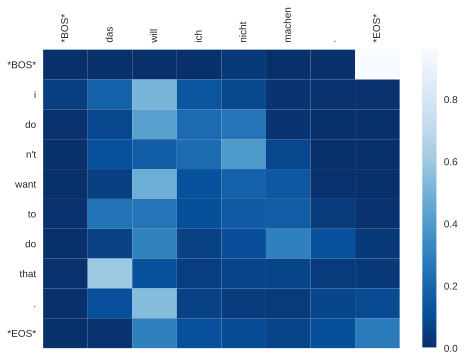

In [17]:
src_sen = 'das will ich nicht machen .'.split()

trg_sen, attn = translator.translate_with_attention(src_sen)

plot_attention(src_sen, trg_sen, attn)

# Your programming tasks

To get started, we used a simplified attention model that does not use the decoder state when selecting information from the encoded sentence. We'll now see if we can improve this.

### What if we don't use the encoder at all?

As a warmup, before we implement a proper attention model, let's see how the decoder will behave when it receives no information at all from the encoder.

Replace the class `MeanAttention` with something that returns a constant zero tensor and see what happens.

What can you say about the sentences generated by the decoder now? 

### Bahdanau's attention model

There are some different ways to implement attention models. We'll describe how to implement the one described in [Bahdanau's paper](https://arxiv.org/pdf/1409.0473.pdf), but you can also consider alternative approaches (see below).

Bahdanau's attention model is a feedforward model with one hidden layer, based on the decoder state and the encoder output. With a slight change in notation from the paper (Section A.1.2), the model looks like this:

$$
a(s_{i-1}, h_j) = v_a^{\top} \tanh(Q s_{i-1} + K h_j)
$$

Here, $h_j$ is an output from the encoded source sentence and $s_{i-1}$ the previous decoder RNN state. $Q$, $K$, and $v_a$ are matrices.

In some discussions, attention is conceptualized in terms of a lookup operation with a *query*, *key*, and *value*. Intuitively, the query specifies what information to search for, the keys match the query, and the values are used to compute the result. In the model above, the representation $Q s_{i-1}$ corresponds to the *query*: it encodes what information we are searching for, based on the previous RNN state, while $K h_j$ corresponds to the *keys*. The values in this case are the encoder representations $h_j$, which we use to compute the aggregated representation.

**Implementing the model**.

Make a new class that has the same structure as `MeanAttention`. You will need to modify `precompute_key` and `forward`. 

`precompute_key` calculates the key representations ($K h_j$). In principle, this could be done inside `forward`, but since this part does not depend on the decoder state, we just have to compute it once. Use a linear model (`nn.Linear`) to compute this.

`forward` has four inputs:
* `query` of shape `(n_sentences, 1, decoder_rnn_size)`: this is the decoder state;
* `precomputed_key` of shape `(n_sentences, n_src_words, hidden_size)`: this is what you computed previous.y;
* `value` of shape `(n_sentences, n_src_words, encoder_rnn_size)`: this is the encoder output;
* `mask` of shape `(n_sentences, n_src_words)`: to mask out padding tokens.

Write code to compute the function `a` above. You will probably need linear models corresponding to $Q$ and $v_a$. Just like `scores` in `MeanAttention`, the result should have the shape `(n_sentences, n_src_words)`. The code that does the masking of padding tokens, softmax and weighted mean can be reused from `MeanAttention`.

If you're confused about the tensor dimensions, like any human being, it might be helpful to print the shapes of the tensors while debugging.

**Running the translator**.

Retrain your translator and see how the BLEU scores are affected. When you have something that seems to work, visualize the attention scores on some sentences.

### Other attention models

[This document](https://lilianweng.github.io/lil-log/2018/06/24/attention-attention.html#summary) contains a nice summary of different ways to implement attention models. For example, the *scaled dot-product* attention, introduced by [Vaswani et al. (2017)](https://papers.nips.cc/paper/7181-attention-is-all-you-need.pdf), is well-known in the context of Transformers and BERT. Can you implement one or more of these attention variants?

Or you might come up with something different? For instance, how about a deterministic attention mechansism where the attention weight $a_i$ is hardcoded to 1 if the decoder is at step $i$?

# Solution

**(a) Disabling the attention mechanism.** If we disable the attention mechanism completely and pass *no* information from the encoded source-language sentence into the decoder, the decoder becomes a straightforwar monolingual language model. If we train it for some time, you can see that it will start to generate some "stereotypical" sentence for the dataset we're using (e.g. TED talks of EU parliament proceedings). Of course, if we try to translate some sentences, we will see that the output sentence will always be the same.

Here is one possible solution. We just set all attention weights (`alphas`) to zero directly.

In [10]:
class NoAttention(nn.Module):
    
    def __init__(self):
        super().__init__()
                   
    def precompute_key(self, encoder_out):
        return None
            
    def forward(self, query, precomputed_key, value, mask):
        n_sen, n_words, enc_rnn_dim = value.shape
        
        alphas = torch.zeros(n_sen, n_words, device=mask.device)        

        #scores.data.masked_fill_(~mask, -float('inf'))
        #alphas = F.softmax(scores, dim=1)        
        
        # The context vector is the weighted sum of the values.
        context = torch.bmm(alphas.unsqueeze(1), value)
        
        return context, alphas

**(b) Implementing Bahdanau's attention model.** To implement the attention mechanism described in the paper, we more or less just apply the formula described in section A.1.2 (or in the instructions above). We define the matrices $K$, $Q$, and $v_a$ as linear models. (We set `bias=False` so that we get just the matrices, not any bias vectors.)

We first apply the key representation model $K$ once for the sentence (in `precompute_key`), while the rest of the model will be applied for each decoding step in `forward`.

While the code superficially corresponds in a straightforward manner to the notation in the paper, there is one subtlety here. When we write
```
query_repr + precomputed_key
```
the `query_repr` is of shape `(n_sentences, 1, hidden_size)` while `precomputed_key` has the shape `(n_sentences, n_src_words, hidden_size)`. In this case, PyTorch will implicitly add the query representation to all dimensions of the key representation.

If we use this model, the translator works better than previously. I got BLEU scores at about 22-23 with the German dataset.

In [11]:
class BahdanauAttention(nn.Module):
   
    def __init__(self, hidden_size, key_size, query_size):
        super().__init__()
       
        self.K = nn.Linear(key_size, hidden_size, bias=False)
        self.Q = nn.Linear(query_size, hidden_size, bias=False)
        self.v_a = nn.Linear(hidden_size, 1, bias=False)
       
    def precompute_key(self, encoder_out):
        # encoder_out shape: (n_sentences, n_src_words, encoder_rnn_size)
        return self.K(encoder_out)
   
    def forward(self, query, precomputed_key, value, mask):
        # query shape: (n_sentences, 1, decoder_rnn_size)
        # precomputed_key shape: (n_sentences, n_src_words, hidden_size)

        query_repr = self.Q(query)
           
        # Calculate scores.
        scores = self.v_a(torch.tanh(query_repr + precomputed_key)).squeeze(2)

        #####
        # The rest is unchanged.
        scores.data.masked_fill_(~mask, -float('inf'))
        alphas = F.softmax(scores, dim=1)       
        context = torch.bmm(alphas.unsqueeze(1), value)
        return context, alphas

If we visualize the attention scores, we can see that they generally seem to focus near the diagonal. This tendency is less clear when there are differences in English and German word order.

(17, 16)


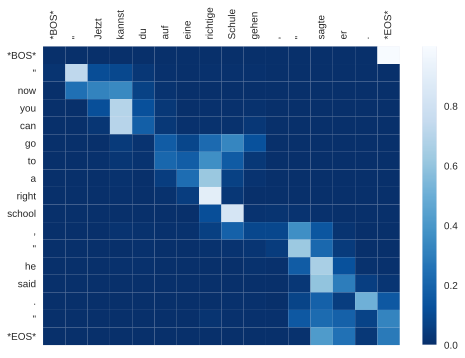

In [32]:
src_sen = '" Jetzt kannst du auf eine richtige Schule gehen , " sagte er .'.split()

trg_sen, attn = translator.translate_with_attention(src_sen)

plot_attention(src_sen, trg_sen, attn)

It might be interesting to consider an example where English and German word orders differ substantially. The word-for-word translation of *Das will ich nicht machen* would be *That want I not do*. To generate the correct English word order, the attention model needs to consider several positions in the German sentence so we can see that the attention scores are a bit more "smudged" here.

(10, 8)


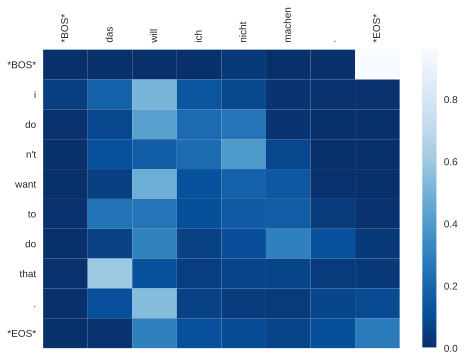

In [30]:
src_sen = 'das will ich nicht machen .'.split()

trg_sen, attn = translator.translate_with_attention(src_sen)

plot_attention(src_sen, trg_sen, attn)

**(c) Other attention models.** Here is an implementation of the *scaled dot-product attention* used in the Transformer model. We just compute the dot products between the key and query representations, and divide them by the square root of the vector lengths. We use the PyTorch method [`bmm`](https://pytorch.org/docs/master/generated/torch.bmm.html) (batch matrix multiplication) to compute the dot products at all positions simultaneously. As usual in PyTorch, we need to keep track of the tensor dimensions: you may refer to the documentation of `bmm` here.

Apart from the way that we compute the "energy" scores, everything is identical to the previous model.

In [ ]:

class ScaledDotAttention(nn.Module):
   
    def __init__(self, hidden_size, key_size, query_size):
        super().__init__()
       
        self.key_layer = nn.Linear(key_size, hidden_size, bias=False)
        self.query_layer = nn.Linear(query_size, hidden_size, bias=False)
        self.scale = 1.0 / np.sqrt(hidden_size)
       
    def precompute_key(self, encoder_out):
        return self.key_layer(encoder_out)
   
    def forward(self, query, precomputed_key, value, mask):
        query = self.query_layer(query)
          
        # query.shape = (n_sen, 1, hidden_size),
        # precomputed_key.shape = (n_sen, n_words, hidden_size)
        # bmm: b*n*m, b*m*p -> b*n*p
                   
        scores = self.scale * torch.bmm(query, precomputed_key.transpose(1, 2)).squeeze(1)
       
        #####
       
        scores.data.masked_fill_(~mask, -float('inf'))
               
        # Turn scores to probabilities.
        alphas = F.softmax(scores, dim=1)       
       
        # The context vector is the weighted sum of the values.
        context = torch.bmm(alphas.unsqueeze(1), value)
       
        return context, alphas